In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

SEED = 1234

# 1. Cargar y preparar el conjunto de datos
datos = pd.read_csv("Temp_Asu20092021.csv")
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)
datos = datos[datos.index.year >= 2019]
datos.dropna(inplace=True)

# 2. Calcular percentiles diarios (95, 50, 5)
percentiles_diarios = datos.resample('D')['Temperatura'].agg(
    Percentil_95=lambda x: np.percentile(x, 95),
    Mediana=lambda x: np.percentile(x, 50),
    Percentil_5=lambda x: np.percentile(x, 5)
)
# Crear la variable objetivo para el día siguiente
percentiles_diarios['Mediana_next'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios.dropna(inplace=True)

# 3. Dividir en entrenamiento y validación
split_date = "2021-01-01"
train = percentiles_diarios[:split_date]
valid = percentiles_diarios[split_date:]

# Definir X y y
y_train, y_valid = train['Mediana'], valid['Mediana']

# 4. Optimización con Optuna para ARIMA
def objective_arima(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    try:
        model = ARIMA(y_train, order=(p, d, q))
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=len(y_valid))
        mae = mean_absolute_error(y_valid, y_pred)
    except Exception:
        return float('inf')  # Penalizar errores de ajuste
    return mae

study_arima = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=SEED))
study_arima.optimize(objective_arima, n_trials=10)

best_params_arima = study_arima.best_params
print("Mejores Hiperparámetros ARIMA:", best_params_arima)

# 5. Entrenar y evaluar el modelo ARIMA con los mejores parámetros
model_arima = ARIMA(y_train, order=(best_params_arima['p'], best_params_arima['d'], best_params_arima['q']))
model_fit_arima = model_arima.fit()
y_pred_arima = model_fit_arima.forecast(steps=len(y_valid))
mae_arima = mean_absolute_error(y_valid, y_pred_arima)
print(f"MAE promedio ARIMA en validación: {mae_arima}")


[I 2024-10-31 05:42:17,357] A new study created in memory with name: no-name-717a5733-9bcd-4803-a4b9-f9b3074cfa6d
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[I 2024-10-31 05:42:17,807] Trial 0 finished with value: 4.974306751342995 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 0 with value: 4.974306751342995.
[I 2024-10-31 05:42:24,601] Trial 1 finished with value: 4.602158079047228 and parameters: {'p': 4, 'd': 2, 'q': 1}. Best is trial 1 with value: 4.602158079047228.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maxim

Mejores Hiperparámetros ARIMA: {'p': 3, 'd': 0, 'q': 2}
MAE promedio ARIMA en validación: 4.433959166093219


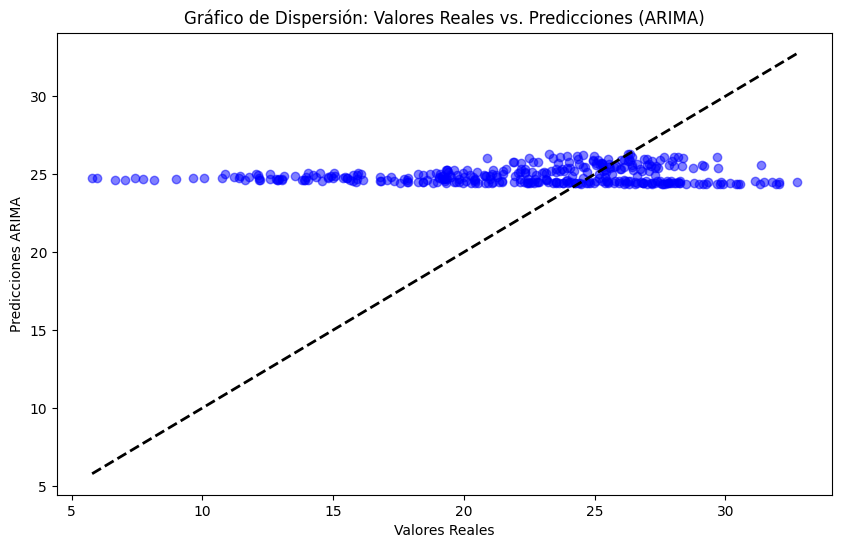

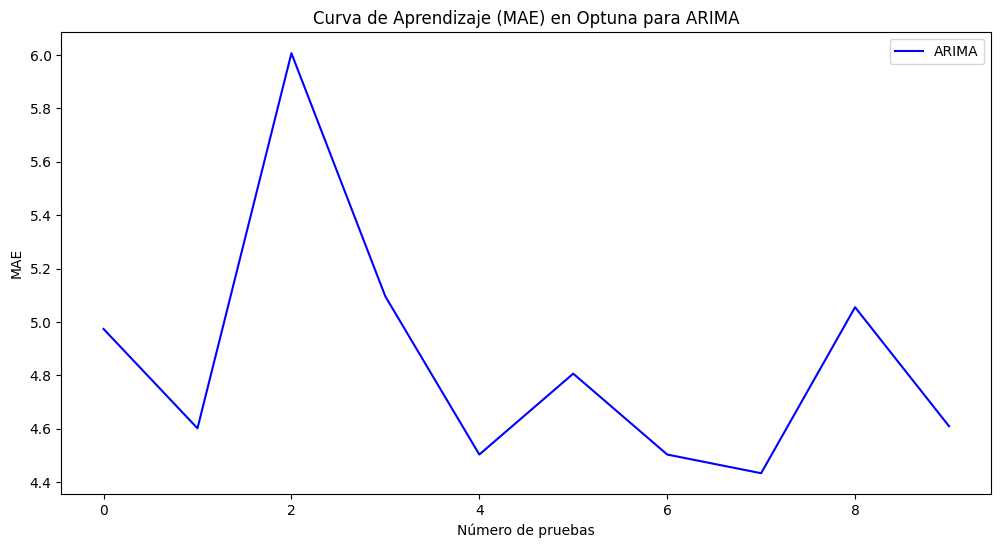

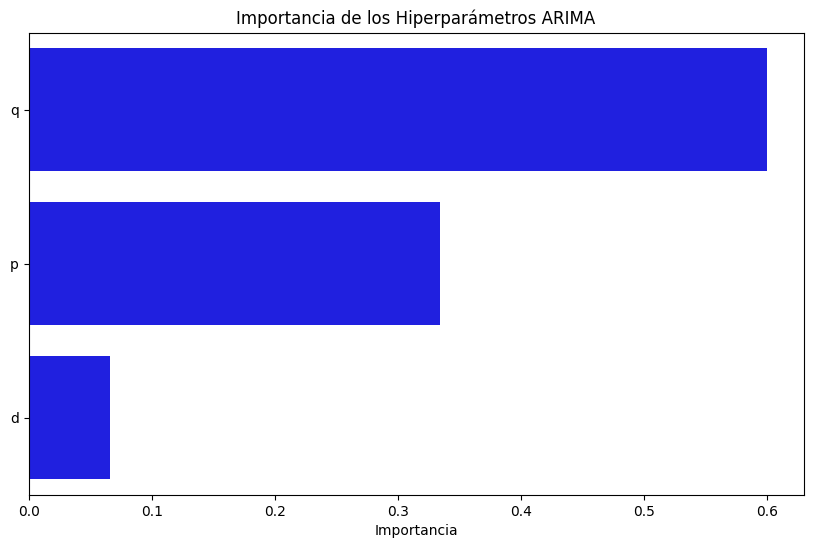

Top 10 resultados de ARIMA en Optuna
   number     value  params_p  params_d  params_q
7       7  4.433959         3         0         2
4       4  4.503979         4         2         2
6       6  4.503979         4         2         2
1       1  4.602158         4         2         1
9       9  4.610102         4         0         3
5       5  4.806896         3         1         0
0       0  4.974307         1         1         2
8       8  5.055677         5         1         2
3       3  5.096061         5         1         3
2       2  6.006967         1         2         5


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.importance import get_param_importances

# 1. Gráfico de Dispersión: Valores Reales vs. Predicciones (ARIMA)
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_arima, alpha=0.5, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones ARIMA")
plt.title("Gráfico de Dispersión: Valores Reales vs. Predicciones (ARIMA)")
plt.show()

# 2. Curva de Aprendizaje del modelo ARIMA
arima_trials = study_arima.trials_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(arima_trials['number'], arima_trials['value'], label='ARIMA', color='blue')
plt.xlabel("Número de pruebas")
plt.ylabel("MAE")
plt.title("Curva de Aprendizaje (MAE) en Optuna para ARIMA")
plt.legend()
plt.show()

# 3. Importancia de los hiperparámetros ARIMA
arima_importance = get_param_importances(study_arima)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(arima_importance.values()), y=list(arima_importance.keys()), color='blue')
plt.title("Importancia de los Hiperparámetros ARIMA")
plt.xlabel("Importancia")
plt.show()

# 4. Mostrar los 10 mejores resultados de Optuna para ARIMA
top_10_arima = arima_trials.nsmallest(10, 'value')
print("Top 10 resultados de ARIMA en Optuna")
print(top_10_arima[['number', 'value', 'params_p', 'params_d', 'params_q']])
